<a href="https://colab.research.google.com/github/jan-de-trop/Telecom-Churn-model/blob/main/Optimized_Telecom_Churn_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telecom Churn Model


In [4]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [5]:
from IPython.display import display, HTML

def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )
def tbl_report(tbl, cols=None, card=10):
    print("Table Shape", tbl.shape)
    dtypes = tbl.dtypes
    nulls = []
    uniques = []
    numuniques = []
    vcs = []
    for col in dtypes.index:
        n = tbl[col].isnull().sum()
        nulls.append(n)
        strdtcol = str(dtypes[col])
        #if strdtcol == 'object' or strdtcol[0:3] == 'int' or strdtcol[0:3] == 'int':
        #print(strdtcol)
        uniqs = tbl[col].unique()
        uniquenums = uniqs.shape[0]
        if uniquenums < card: # low cardinality
            valcounts = pd.value_counts(tbl[col], dropna=False)
            vc = "\n".join(["{}:{}".format(k,v) for k, v in valcounts.items()])
        else:
            vc='HC' # high cardinality
        uniques.append(uniqs)
        numuniques.append(uniquenums)
        vcs.append(vc)
    nullseries = pd.Series(nulls, index=dtypes.index)
    uniqueseries = pd.Series(uniques, index=dtypes.index)
    numuniqueseries = pd.Series(numuniques, index=dtypes.index)
    vcseries = pd.Series(vcs, index=dtypes.index)
    df = pd.concat([dtypes, nullseries, uniqueseries, numuniqueseries, vcseries], axis=1)
    df.columns = ['dtype', 'nulls', 'uniques', 'num_uniques', 'value_counts']
    if cols:
        return pretty_print(df[cols])
    return pretty_print(df)


## Preprocessing

This is a dataset from a telecom company, of their customers. Based on various features of these customers and their calling plans, we want to predict if a customer is likely to leave the company. This is expensive for the company, as a lost customer means lost monthly revenue!

In [6]:
#data set from yhathq: http://blog.yhathq.com/posts/predicting-customer-churn-with-sklearn.html
dfchurn=pd.read_csv("/content/churn.csv")
dfchurn.head()

State  Account Length  Area Code  ... Intl Charge CustServ Calls  Churn?
0    KS             128        415  ...        2.70              1  False.
1    OH             107        415  ...        3.70              1  False.
2    NJ             137        415  ...        3.29              0  False.
3    OH              84        408  ...        1.78              2  False.
4    OK              75        415  ...        2.73              3  False.

[5 rows x 21 columns]

### Type Driven Transformation

![](https://github.com/JKashyap46/Lab4-1/blob/main/slides_improving/6.png?raw=1)

In [7]:
tbl_report(dfchurn, cols=['dtype', 'nulls', 'num_uniques', 'value_counts'])

Table Shape (3333, 21)


Ok, so nulls. We have been given a relatively clean dataset.

But note that State is categorical, and Area code is categorical too, and neither have an ordering on them. Still, for the purposes of a decision tree, we'll keep an ordinal encoding for them. International Plan and Voicemail plan are booleans. The rest of the dataframe seems ok.

In [8]:
dfchurn["Int'l Plan"] = dfchurn["Int'l Plan"]=='yes'
dfchurn["VMail Plan"] = dfchurn["VMail Plan"]=='yes'
dfchurn["State"] = dfchurn["State"].astype("category")

In [9]:
dfchurn["Area Code"] = dfchurn["Area Code"].astype("category")

In [10]:
tbl_report(dfchurn, cols=['dtype', 'nulls', 'num_uniques', 'value_counts'])

Table Shape (3333, 21)


In [11]:
dfchurn.head()

State  Account Length Area Code  ... Intl Charge  CustServ Calls  Churn?
0    KS             128       415  ...        2.70               1  False.
1    OH             107       415  ...        3.70               1  False.
2    NJ             137       415  ...        3.29               0  False.
3    OH              84       408  ...        1.78               2  False.
4    OK              75       415  ...        2.73               3  False.

[5 rows x 21 columns]

### Preparing for EDA

![](https://github.com/JKashyap46/Lab4-1/blob/main/slides_improving/8.png?raw=1)

What's the asymmetry in our data set?

In [12]:
ychurn = np.where(dfchurn['Churn?'] == 'True.',1,0)
100*ychurn.mean()

14.491449144914492


While it is not particularly bad leakage, its a bad idea to EDA using the entire dataset, because if you do feature selection based on the entire dataset through this EDA, you are leaking information from the test set into the training set. As we have said before, best for the boss to keep the test set locked up in a cupboard.

In [13]:
from sklearn.model_selection import train_test_split
churntrain_index, churntest_index = train_test_split(range(dfchurn.shape[0]), stratify = ychurn, train_size=0.6, random_state=1991)
churnmask=np.ones(dfchurn.shape[0], dtype='int')
churnmask[churntrain_index]=1
churnmask[churntest_index]=0
churnmask = (churnmask==1)
churnmask

array([ True,  True,  True, ...,  True, False,  True])

In [14]:
churntrain = dfchurn[churnmask]
churntest = dfchurn[~churnmask]

In [15]:
np.mean(churntrain['Churn?'] == 'True.'), np.mean(churntest['Churn?'] == 'True.')

(0.14507253626813407, 0.1446776611694153)

## EDA

![](https://github.com/JKashyap46/Lab4-1/blob/main/slides_improving/9.png?raw=1)

In [16]:
cont_vars=['Account Length', 'VMail Message', 
                 'Day Mins', 'Day Calls', 'Day Charge', 
                 'Eve Mins', 'Eve Calls', 'Eve Charge', 
                 'Night Mins', 'Night Calls', 'Night Charge', 
                 'Intl Mins', 'Intl Calls', 'Intl Charge', 
                 'CustServ Calls']
cat_vars=["Int'l Plan", 'VMail Plan', 'State', 'Area Code' ]

In [17]:
churntrain[cont_vars].describe()

Account Length  VMail Message  ...  Intl Charge  CustServ Calls
count     1999.000000    1999.000000  ...  1999.000000     1999.000000
mean       101.092046       8.517759  ...     2.749550        1.552776
std         40.468534      13.872383  ...     0.767966        1.307594
min          1.000000       0.000000  ...     0.000000        0.000000
25%         74.000000       0.000000  ...     2.240000        1.000000
50%        101.000000       0.000000  ...     2.750000        1.000000
75%        128.000000      21.000000  ...     3.270000        2.000000
max        232.000000      50.000000  ...     5.400000        9.000000

[8 rows x 15 columns]

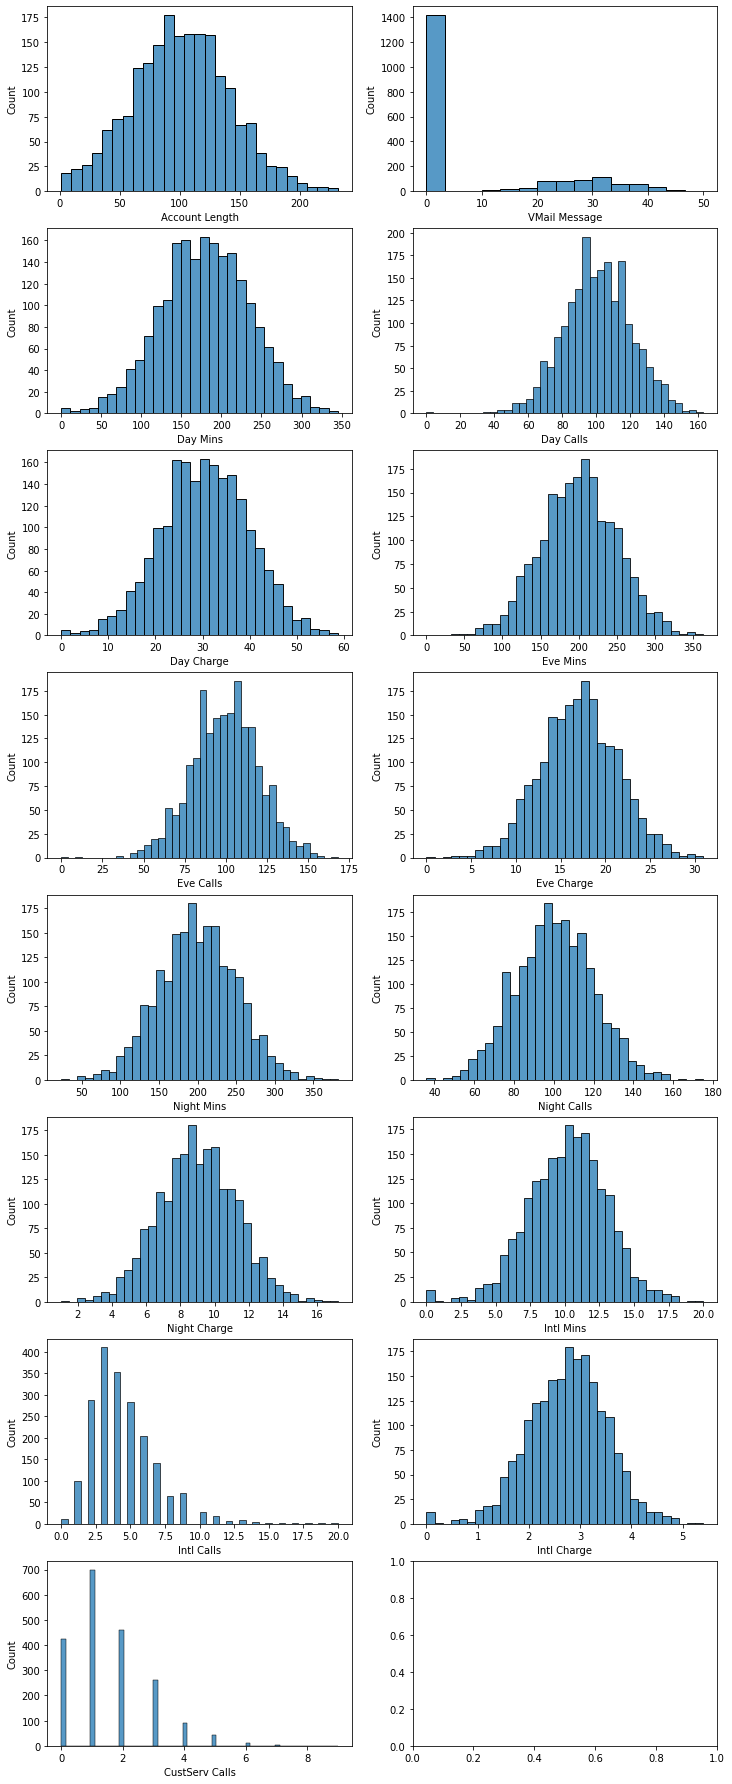

In [18]:
import math
ncols = 2
nrows = math.ceil(len(cont_vars)/ncols)
fig, axen = plt.subplots(nrows, ncols, figsize = (12, nrows*4))
for v, ax in zip(cont_vars, axen.ravel()):
    sns.histplot(churntrain[v], ax=ax)

Most of the features follow gaussian distributions except for International Calls and Customer Service calls, which follow Poisson distributions, and Voicemail message which has large 0-inflation.

In [19]:
churntrain[cat_vars].describe()

Int'l Plan VMail Plan State  Area Code
count        1999       1999  1999       1999
unique          2          2    51          3
top         False      False    WV        415
freq         1806       1414    69        996

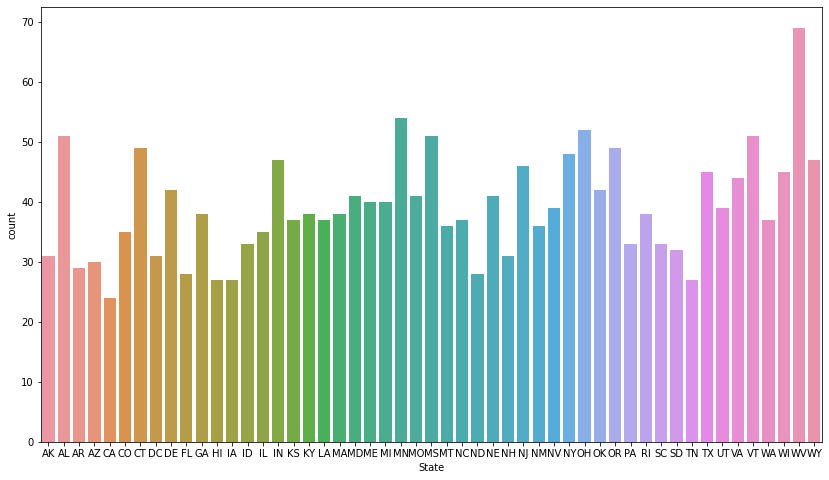

In [20]:
fig, ax = plt.subplots(figsize=(14,8))
sns.countplot(x=churntrain.State, ax=ax)

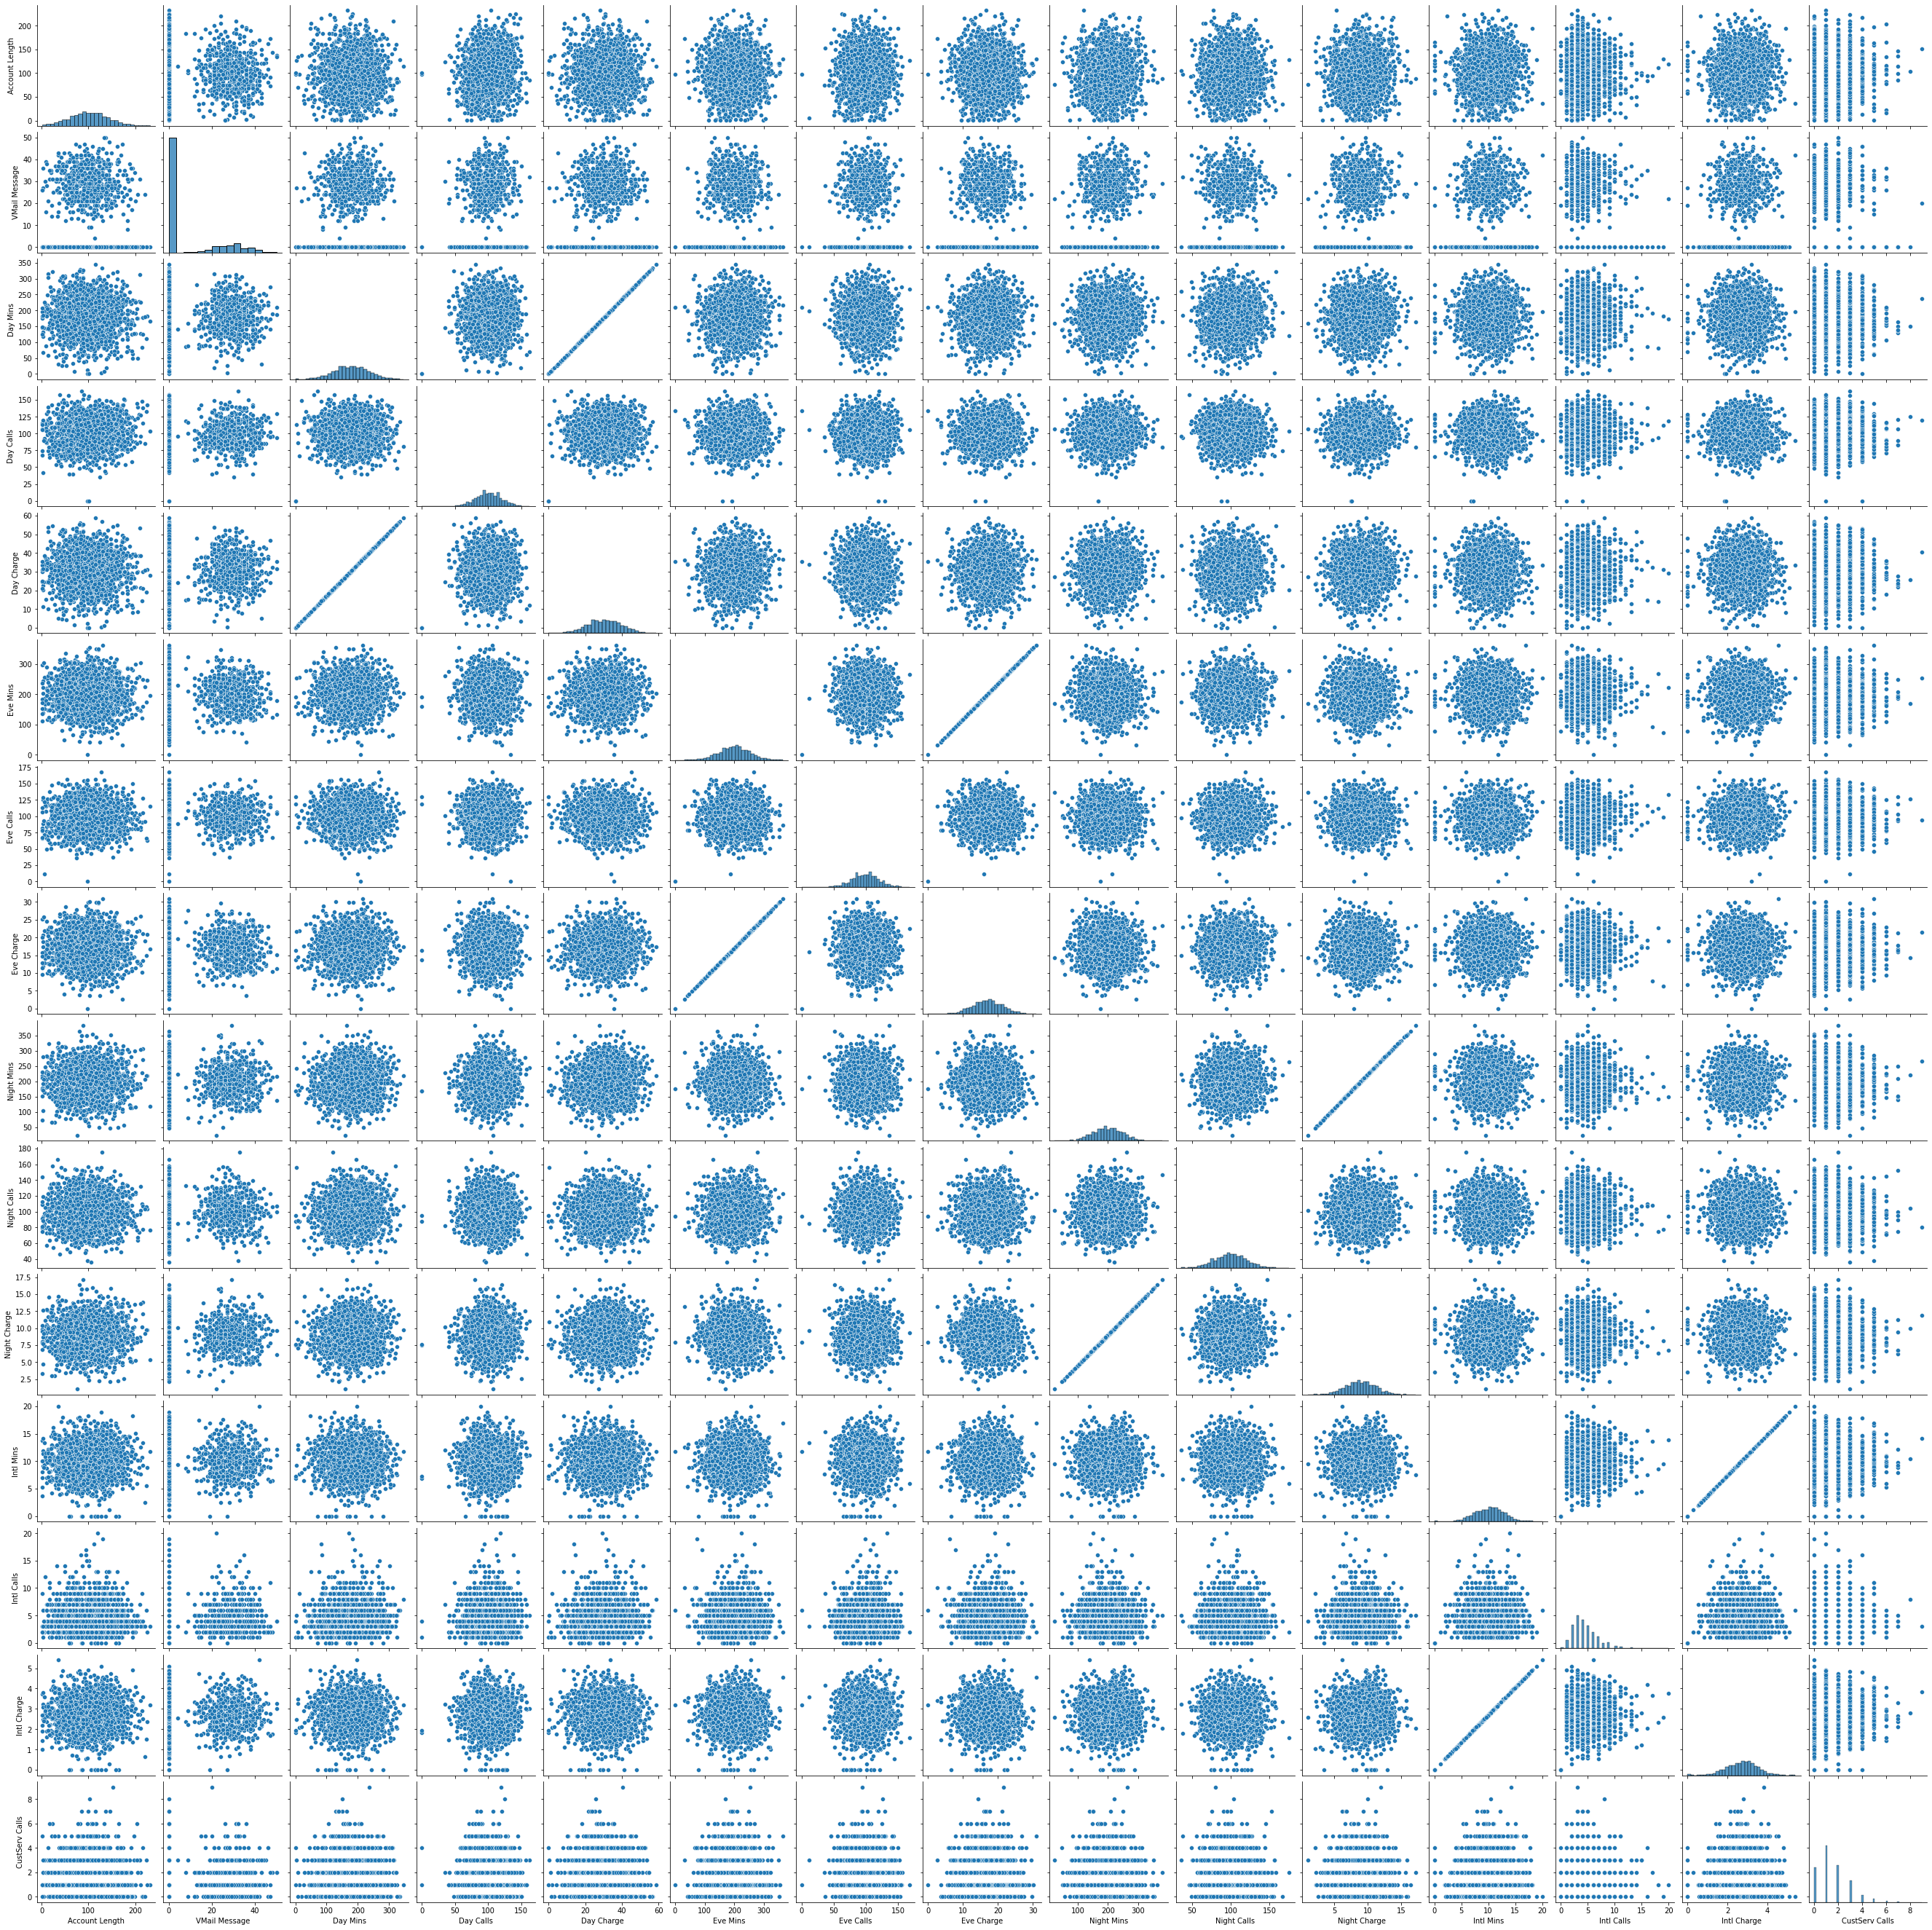

In [21]:
sns.pairplot(data=churntrain[cont_vars])

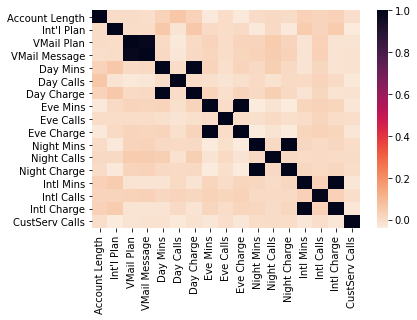

In [22]:
# your code here
sns.heatmap(churntrain.corr(method='spearman'),cmap='rocket_r')

![](https://github.com/JKashyap46/Lab4-1/blob/main/slides_improving/12.png?raw=1)

## Modeling


We already made the train test split.

We now need to split columns out by their types and handle them differently. But first let us set up baseline models. For this we'll directly compute our desired metric, cost. The definitions of the models themselves dont need costs, but costs are how we will evaluate them.

## Baseline Models


The imbalance in our dataset is 14% positives.

This means that a classifier which predicts that EVERY customer is a negative (does not churn) has an accuracy rate of 85-86%. 

So, accuracy cannot be the right metric.

## Choice of Loss and metric


In [23]:
admin_cost=3
offer_cost=100
clv=1000#customer lifetime value

- TN=people we predicted not to churn who wont churn. We associate no cost with this as they continue being our customers
- FP=people we predict to churn. Who wont. Lets associate a `admin_cost+offer_cost` cost per customer with this as we will spend some money on getting them not to churn, but we will lose this money.
- FN=people we predict wont churn. And we send them nothing. But they will. This is the big loss, the `clv`
- TP= people who we predict will churn. And they will. These are the people we can do something with. So we make them an offer. Say a fraction f accept it. Our cost is

`f * (offer_cost+admin_cost) + (1-f)*(clv+admin_cost)`

This model can definitely be made more complex.

Lets assume a conversion fraction of 0.5

In [24]:
conv = 0.5 # f
tnc = 0.
fpc = admin_cost+offer_cost
fnc = clv
tpc = conv*(offer_cost+admin_cost) + (1. - conv)*(clv+admin_cost)

We make the cost matrix...

In [25]:
cost=np.array([[tnc,fpc],[fnc, tpc]])
print(cost)

[[   0.  103.]
 [1000.  553.]]


..and write the function to calculate for the average cost...

In [26]:
def average_cost(y, ypred, cost):
    c=confusion_matrix(y,ypred)
    score=np.sum(c*cost)/np.sum(c)
    return score

#### No customer churns and we send nothing



In [27]:
testchurners=dfchurn['Churn?'][~churnmask].values=='True.'

In [28]:
testsize = dfchurn[~churnmask].shape[0]
ypred_dste = np.zeros(testsize, dtype="int")
from sklearn.metrics import confusion_matrix
print(confusion_matrix(testchurners, ypred_dste))

[[1141    0]
 [ 193    0]]


In [29]:
dsteval=average_cost(testchurners, ypred_dste, cost)
dsteval

144.6776611694153

Not doing anything costs us 145 per customer.



#### All customers churn, we send everyone

In [30]:
ypred_ste = np.ones(testsize, dtype="int")
print(confusion_matrix(testchurners, ypred_ste))

[[   0 1141]
 [   0  193]]


In [31]:
# your code here
steval = average_cost(testchurners, ypred_ste, cost)
steval

168.10494752623688

Make offers to everyone costs us even more, not surprisingly. The first model is the one to beat.





## Logistic Regression Baseline


In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        print("SCORE FUNC", score_func)
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print("BEST", gs.best_params_, gs.best_score_)
    best = gs.best_estimator_
    return best
def do_classify(clf, parameters, indf, 
                featurenames, targetname, target1val, 
                reuse_split, mask=False, 
                score_func=None, n_folds=5, n_jobs=1):
    X=indf[featurenames]
    y=(indf[targetname]==target1val)*1
    if not mask:
        print("using reuse split")
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'][featurenames], reuse_split['Xtest'][featurenames], reuse_split['ytrain'], reuse_split['ytest']
    else: # mask is to be used
        print("using mask")
        Xtrain, Xtest, ytrain, ytest = X[reuse_split], X[~reuse_split], y[reuse_split], y[~reuse_split]
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("############# based on standard predict 0.5 ################")
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    print(confusion_matrix(ytest, clf.predict(Xtest)))
    print("########################################################")
    return clf, dict(Xtrain=Xtrain, ytrain=ytrain, Xtest=Xtest, ytest=ytest)

In [33]:
pure_cat_vars = ['State', 'Area Code']

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
# set up standardization
ss = StandardScaler()
# oe hot encoding
oh = OneHotEncoder()
# continuous variables need to be standardized
cont_pipe = Pipeline([("scale", ss)])
# categorical variables need to be one hot encoded
cat_pipe = Pipeline([('onehot', oh)])
# combine both into a transformer
transformers = [('cont', cont_pipe, cont_vars), ('cat', cat_pipe, pure_cat_vars)]
# apply transformer to relevant columns. Nothing will be done for the rest
ct = ColumnTransformer(transformers=transformers, remainder="passthrough")
# create a pipeline so that we are not leaking data from validation to train in the individual folds
pipe = Pipeline(steps=[('ct', ct), ('model', LogisticRegression(max_iter=10000, penalty='l2'))])
# in paramgrid we dont use C but use model__C corresponding to the name in the pipeline
paramgrid = dict(model__C=[1000, 100, 10, 1, 0.1, 0.01, 0.001])

In [35]:
from sklearn.metrics import roc_auc_score
pipe, reuse_split=do_classify(pipe, paramgrid, dfchurn, 
                              cont_vars+cat_vars, 'Churn?', "True.", 
                              churnmask, mask=True, score_func='roc_auc')

using mask
SCORE FUNC roc_auc
BEST {'model__C': 0.1} 0.8075459530614382
############# based on standard predict 0.5 ################
Accuracy on training data: 0.86
Accuracy on test data:     0.86
[[1115   26]
 [ 156   37]]
########################################################


In [36]:
Xtrain, ytrain, Xtest, ytest = reuse_split['Xtrain'], reuse_split['ytrain'], reuse_split['Xtest'],reuse_split['ytest']

And calculate the average cost

In [37]:
average_cost(ytest, pipe.predict(Xtest), cost)

134.28710644677662

Ok! We did better! But is this the true value of our cost? To answer this question, we need to ask a question: what exactly is `clf.predict` doing? (we did not have to worry about that in the baselines as there was no threshold based prediction)

### ROC Curve

Our dataset is a very lopsided data set with 86% of samples being negative. We now know that in such a case, accuracy is not a very good measure of a classifier.


ROC curves are actually a set of classifiers, in which we move the threshold for classifying a sample as positive from 0 to 1. (In the standard scenario, where we use classifier accuracy, this threshold is implicitly set at 0.5).

![](https://github.com/JKashyap46/Lab4-1/blob/main/slides_improving/37.png?raw=1)

![](https://github.com/JKashyap46/Lab4-1/blob/main/slides_improving/38.png?raw=1)

In [38]:
from sklearn.metrics import roc_curve, auc

In [39]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=5,  proba=True, skip=0, initial = False):
    if not ax:
        ax=plt.gca()
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', lw=2, alpha=0.4, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', lw=2, alpha=0.4, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in range(0, fpr.shape[0],labe):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

We make a ROC curve for the logistic regression model...

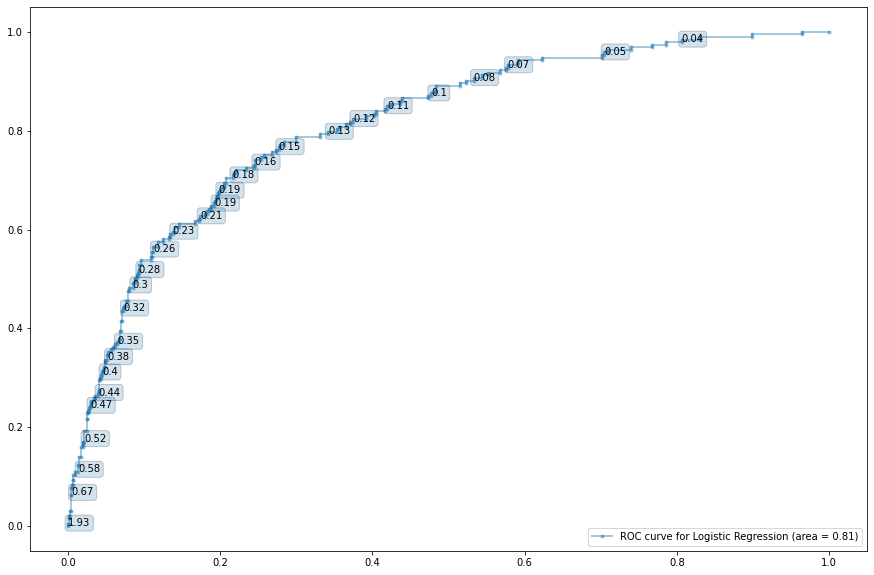

In [41]:
# your code here
fig, ax = plt.subplots(figsize=(15,10))
make_roc('Logistic Regression', pipe, ytest, Xtest, labe=10)

We print the classification report..

In [42]:
from sklearn.metrics import classification_report
print(classification_report(ytest, pipe.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.88      0.98      0.92      1141
           1       0.59      0.19      0.29       193

    accuracy                           0.86      1334
   macro avg       0.73      0.58      0.61      1334
weighted avg       0.84      0.86      0.83      1334



### Random Forest


In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder

In [44]:
from sklearn.compose import make_column_transformer
col_trans = make_column_transformer(
                        (OrdinalEncoder(),pure_cat_vars),
                        remainder = "passthrough"
                        )

In [45]:
rf = RandomForestClassifier(n_estimators=300)

In [46]:
from sklearn.pipeline import make_pipeline
rf = make_pipeline(col_trans, rf)

In [48]:
rf, _  = do_classify(rf, {"randomforestclassifier__max_features": range(2,10,1)},
    dfchurn, cont_vars+cat_vars, 'Churn?', "True.", 
    reuse_split=reuse_split, score_func="roc_auc")

using reuse split
SCORE FUNC roc_auc
BEST {'randomforestclassifier__max_features': 4} 0.9019985139137999
############# based on standard predict 0.5 ################
Accuracy on training data: 1.00
Accuracy on test data:     0.95
[[1129   12]
 [  60  133]]
########################################################


### Comparison

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
make_roc("Logistic regression",pipe, ytest, Xtest, ax=ax, labe=50, initial=True)
make_roc("Random Forest",rf, ytest, Xtest, ax, labe=10)

### Model visualization

![](https://github.com/JKashyap46/Lab4-1/blob/main/slides_improving/34.png?raw=1)


In [ ]:
print(classification_report(ytest, rf.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1141
           1       0.89      0.73      0.80       193

    accuracy                           0.95      1334
   macro avg       0.92      0.85      0.88      1334
weighted avg       0.94      0.95      0.94      1334



Probability Histogram

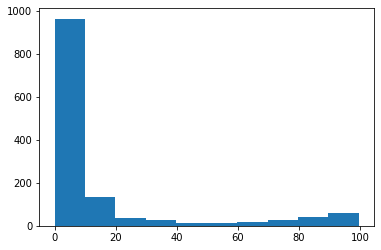

In [ ]:
plt.hist(rf.predict_proba(Xtest)[:,1]*100);

Margin plot for a threshold of 0.2 

Text(0, 0.5, 'margin = $(2y -1)\\times (p-0.5)$')

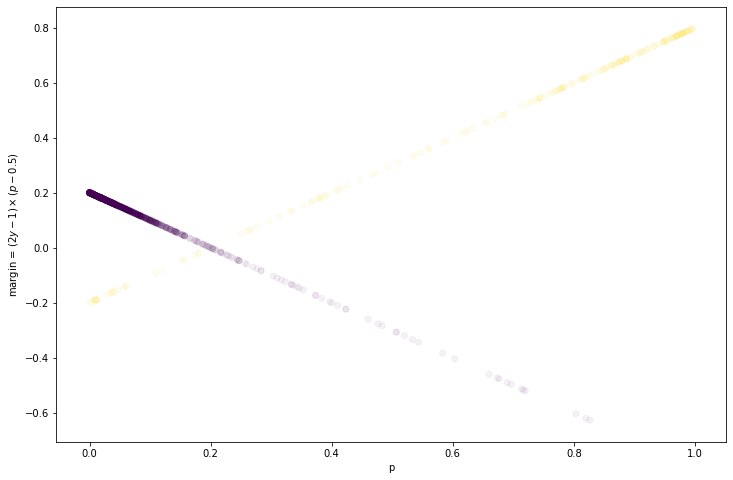

In [ ]:
thresh = 0.2
prob_pos = rf.predict_proba(Xtest)[:, 1]
plt.figure(figsize=(12, 8))
margins = (prob_pos-thresh)*(2*ytest-1)
plt.scatter(prob_pos, margins, c=ytest, alpha=0.05)
plt.xlabel('p')
plt.ylabel(r"margin = $(2y -1)\times (p-0.5)$")

Histogram of the margins 

(0, 50)

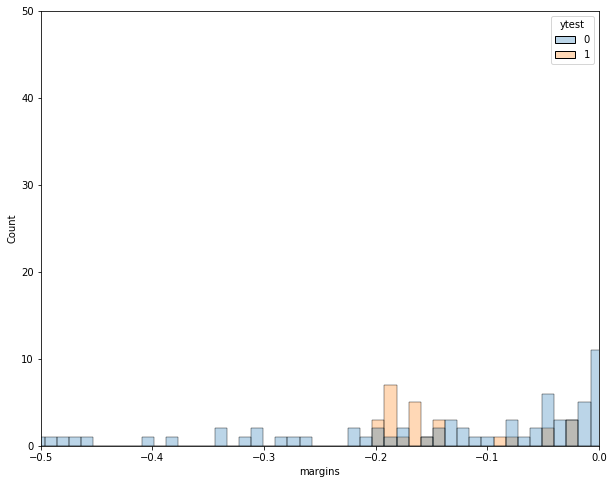

In [ ]:
plt.figure(figsize=(10, 8))
data = pd.DataFrame(dict(margins=margins, ytest = ytest))
sns.histplot(data=data, x='margins', hue='ytest', alpha=0.3)
plt.xlim(-0.5, 0)
plt.ylim(0, 50)

In [ ]:
loglosses = - (ytest*np.log(prob_pos) + \
    (1-ytest)*np.log(1-prob_pos))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'logloss = - $(ylog p _(1-y)log(1-p)$')

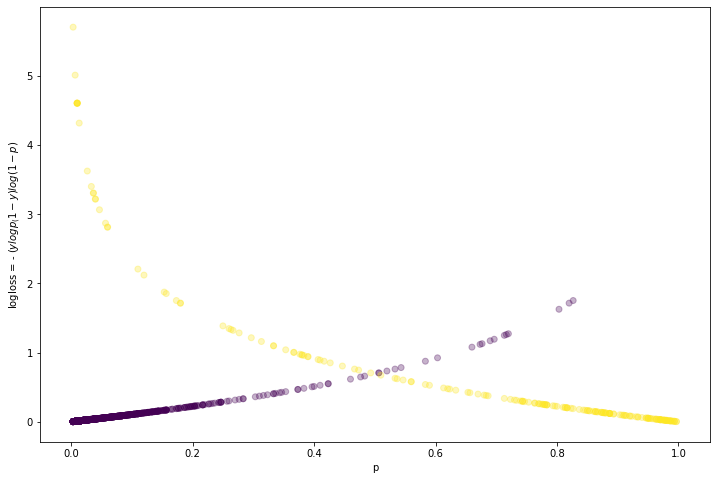

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(prob_pos, loglosses, c=ytest, alpha=0.3)
plt.xlabel('p')
plt.ylabel(r"logloss = - $(ylog p _(1-y)log(1-p)$")

## Cost based analysis and visualization


![](https://github.com/JKashyap46/Lab4-1/blob/main/slides_improving/39.png?raw=1)



We can use the utility or cost matrix to provide a  threshold to pick for our classifier. 

The key idea is that we want to minimize cost on our test set, so for each sample, simply pick the class which does that. 

To understand this, lets follow through with a bit of math:


We simply weigh each combinations loss by the probability that that combination can happen:

$$ R_{g}(x) = \sum_y l(y,g(x)) p(y|x)$$

That is, we calculate the **average risk** over all choices y, of making choice g for a given sample.

Then, if we want to calculate the overall risk, given all the samples in our set, we calculate:

$$R(g) = \sum_x p(x) R_{g}(x)$$

It is sufficient to minimize the risk at each point or sample to minimize the overall risk since $p(x)$ is always positive.

Consider the two class classification case. Say we make a "decision g about which class" at a sample x. Then:

$$R_g(x) = l(1, g)p(1|x) + l(0, g)p(0|x).$$

Then for the "decision" $g=1$ we have:

$$R_1(x) = l(1,1)p(1|x) + l(0,1)p(0|x),$$

and for the "decision" $g=0$ we have:

$$R_0(x) = l(1,0)p(1|x) + l(0,0)p(0|x).$$

Now, we'd choose $1$ for the sample at $x$ if:

$$R_1(x) \lt R_0(x).$$

$$ P(1|x)(l(1,1) - l(1,0)) \lt p(0|x)(l(0,0) - l(0,1))$$

This gives us a ratio `r` between the probabilities to make a prediction. We assume this is true for all samples.

So, to choose '1':

$$p(1|x) \gt r P(0|x) \implies r=\frac{l(0,1) - l(0,0)}{l(1,0) - l(1,1)} =\frac{c_{FP} - c_{TN}}{c_{FN} - c_{TP}}$$

This may also be written as:

$$P(1|x) \gt t = \frac{r}{1+r}$$.

If we assume that True positives and True negatives have no cost, and the cost of a false positive is equal to that of a false positive, then $r=1$ and the threshold is the usual intutive $t=0.5$.

In [ ]:
cost

array([[   0.,  103.],
       [1000.,  553.]])

In [ ]:
def rat(cost):
    return (cost[0,1] - cost[0,0])/(cost[1,0]-cost[1,1])

In [ ]:
def c_repredict(est, c, xtest):
    r = rat(c)
    print(r)
    t=r/(1.+r)
    print("t=", t)
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 >= t)*1
    return ypred

In [ ]:
average_cost(ytest, c_repredict(rf, cost, Xtest), cost)

0.23042505592841164
t= 0.18727272727272729


94.99925037481259

In [ ]:
average_cost(ytest, c_repredict(pipe, cost, Xtest), cost)

0.23042505592841164
t= 0.18727272727272729


118.3088455772114

So the random forest does better on the cost as well, once we have 


found a better threshold. Notice that the threshold is much smaller. Lets plot cost against threshold:

In [ ]:
def repredict(est,t, xtest):
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 >= t)*1
    return ypred

Text(0, 0.5, 'Cost')

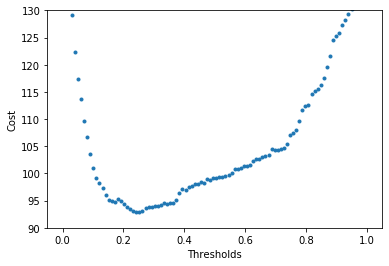

In [ ]:
ts = np.linspace(0., 1., 100)
plt.plot(ts, [average_cost(ytest, repredict(rf, t, Xtest), cost) for t in ts], '.' )
plt.ylim(90, 130)
plt.xlabel('Thresholds')
plt.ylabel('Cost')

## Model selection from Cost and ROC

Notice that the ROC curve has a very interesting property: if you look at the confusion matrix , TPR is only calculated from the observed "1" row while FPR is calculated from the observed '0' row. This means that the ROC curve is independent of the class balance/imbalance on the test set, and thus works for all ratios of positive to negative samples. The balance picks a point on the curve, as you can read below.

Lets rewrite the cost equation from before.

\begin{eqnarray}
Cost &=& c(1P,1A) \times p(1P,1A) + c(1P,0A) \times p(1P,0A) + c(0P,1A) \times p(0P,1A) + c(0P,0A) \times p(0P,0A) \\
&=& p(1A) \times \left ( c(1P,1A) \times p(1P | 1A) + c(0P,1A) \times p(0P | 1A) \right ) \\
&+& p(0A) \times \left ( c(1P,0A) \times p(1P,0A) + c(0P,0A) \times p(0P | 0A) \right ) \\
&=& p(1A) \times \left ( c(1P,1A) \times TPR + c(0P,1A) \times (1 - TPR)\right ) \\
&+& p(0A) \times \left ( c(1P,0A) \times FPR + c(0P,0A) \times (1 - FPR) \right )
\end{eqnarray}


This can then be used to write TPR in terms of FPR, which as you can see from below is a line if you fix the cost. So lines on the graph correspond to a fixed cost. Of course they must intersect the ROC curve to be acceptable as coming from our classifier.

$$TPR = \frac{1}{p(1A)(c_{FN} - c_{TP})} \left ( p(1A) c_{FP} + p(0A) c_{TN} - Cost \right ) + r \frac{p(0A)}{p(1A)} \times FPR$$

So one can use the tangent line method to find the classifier we ought to use and multiple questions about ROC curves now get answered.

(1) For a balanced data set, with equal misclassification costs, and no cost for true positives and true negatives, the slope is 1. Thus 45 degree lines are what we want, and hence closest to the north west corner, as thats where a 45 degree line would be tangent.
(2) Classifiers which have some part of their ROC curve closer to the northwest corner than others have tangent lines with higher intercepts and thus lower cost
(3) For any other case, find the line!

In [ ]:
print(rat(cost))
slope = rat(cost)*(np.mean(ytest==0)/np.mean(ytest==1))
slope

0.23042505592841164


1.3622538280534595

In [ ]:
z1=np.arange(0.,1., 0.02)
def plot_line(ax, intercept):
    plt.figure(figsize=(12,12))
    ax=plt.gca()
    ax.set_xlim([0.0,1.0])
    ax.set_ylim([0.0,1.0])
    make_roc("log",pipe, ytest, Xtest, ax, labe=30)
    make_roc("rf",rf, ytest, Xtest, ax, labe=30)
    ax.plot(z1 , slope*z1 + intercept, 'k-')

In [ ]:
from IPython.html.widgets import interact, fixed
interact(plot_line, ax=fixed(ax), intercept=(0.0,1.0, 0.02))

C:\ProgramData\Anaconda3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


interactive(children=(FloatSlider(value=0.5, description='intercept', max=1.0, step=0.02), Output()), _dom_cla…

<function __main__.plot_line(ax, intercept)>

## Cost curves

The proof is always in the pudding. So far we have used a method to calculate a rough threshold from the cost/utility matrix, and seen the ROC curve which implements one classifier per threshold to pick an appropriate model. But why not just plot the cost/profit (per person) per threshold on a ROC like curve to see which classifier maximizes profit/minimizes cost? 

Just like in a ROC curve, we go down the sorted (by score or probability) list of samples. We one-by-one add an additional sample to our positive samples, noting down the attendant classifier's TPR and FPR and threshold. In addition to what we do for the ROC curve, we now also note down the percentage of our list of samples predicted as positive. Remember we start from the mostest positive, where the percentage labelled as positive would be minuscule, like 0.1 or so and the threshold like a 0.99 in probability or so. As we decrease the threshold, the percentage predicted to be positive clearly increases until everything is predicted positive at a threshold of 0. What we now do is, at each such additional sample/threshold (given to us by the `roc_curve` function from `sklearn`), we calculate the expected profit per person and plot it against the percentage predicted positive by that threshold to produce a profit curve. Thus, small percentages correspond to samples most likely to be positive: a percentage of 8% means the top 8% of our samples ranked by likelihood of being positive.

As in the ROC curve case, we use `sklearn`'s `roc_curve` function to return us a set of thresholds with TPRs and FPRs.

In [ ]:
def percentage(tpr, fpr, priorp, priorn):
    perc = tpr*priorp + fpr*priorn
    return perc
def av_cost2(tpr, fpr, cost, priorp, priorn):
    profit = priorp*(cost[1][1]*tpr+cost[1][0]*(1.-tpr))+priorn*(cost[0][0]*(1.-fpr) +cost[0][1]*fpr)
    return profit
def plot_cost(name, clf, ytest, xtest, cost, ax=None, threshold=False, labe=200, proba=True):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    priorp=np.mean(ytest)
    priorn=1. - priorp
    ben=[]
    percs=[]
    for i,t in enumerate(thresholds):
        perc=percentage(tpr[i], fpr[i], priorp, priorn)
        ev = av_cost2(tpr[i], fpr[i], cost, priorp, priorn)
        ben.append(ev)
        percs.append(perc*100)
    ax.plot(percs, ben, '-', alpha=0.3, markersize=5, label='cost curve for %s' % name)
    if threshold:
        label_kwargs = {}
        label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
        )
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (percs[k], ben[k]), **label_kwargs)
    ax.legend(loc="lower right")
    return ax

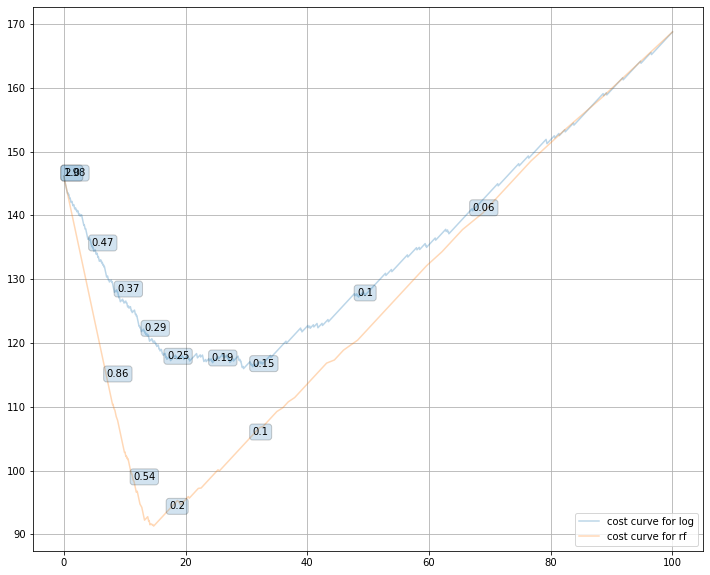

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
ax = plot_cost("log",pipe, ytest, Xtest, cost, ax=ax, threshold=True, labe=30);
plot_cost("rf",rf, ytest, Xtest, cost, ax, threshold=True, labe=30);
ax.grid()
ax.set_xlabel('% Predicted Positive')
ax.set_ylabel('Cost')

In [ ]:
costmaker = lambda f: np.array([[tnc, fpc],[fnc, f*(offer_cost+admin_cost) + (1. - f)*(clv+admin_cost)]])

What is only 30% converted?

In [ ]:
costmaker(0.3)

array([[   0.,  103.],
       [1000.,  733.]])

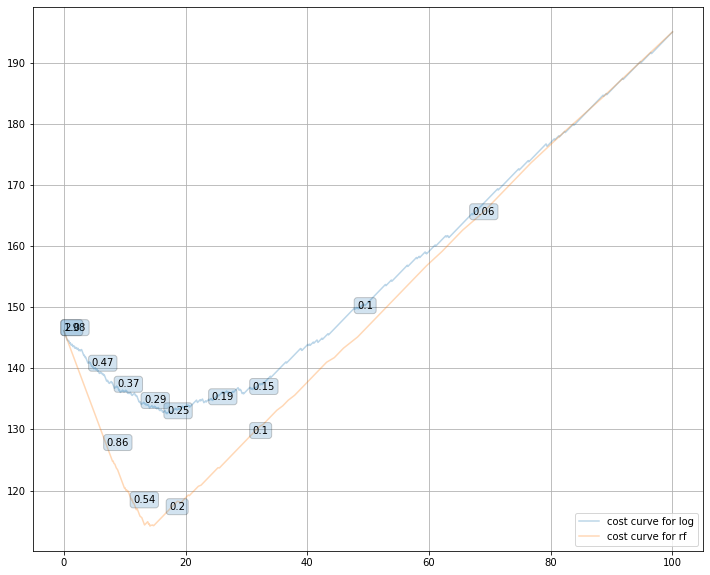

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
ax = plot_cost("log",pipe, ytest, Xtest, costmaker(0.3), ax=ax, threshold=True, labe=30);
plot_cost("rf",rf, ytest, Xtest, costmaker(0.3), ax, threshold=True, labe=30);
ax.grid()

Then we dont get a lot of cost reductions.

## Feature interpretation and Importances



In [ ]:
from sklearn.inspection import plot_partial_dependence, permutation_importance


In [ ]:
def feature_importance(cols, fi, fistd = 0):
    return pd.DataFrame({'features':cols, 'importance':fi, 'importance_std': fistd}
                       ).sort_values('importance', ascending=False)

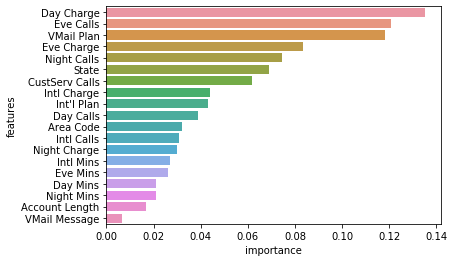

In [ ]:
feat = feature_importance(dfchurn.columns, rf.feature_importances_)
sns.barplot(data=churntrain, y="features", x="importance")

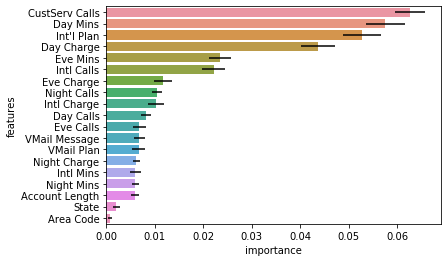

In [ ]:
feat = feature_importance(dfchurn.columns, rf.feature_importances_)
sns.barplot(data=churntest, y="features", x="importance")

Plot the permutation feature importance with testing set

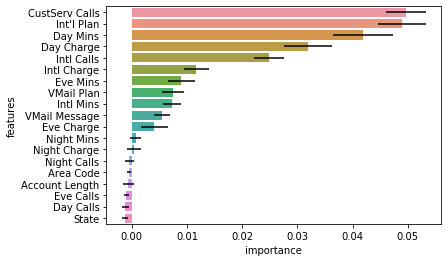

In [ ]:
perm = permutation_importance(rf, Xtest, ytest, n_repeats=30)

In [ ]:
from rfpimp import plot_corr_heatmap, plot_dependence_heatmap, feature_dependence_matrix

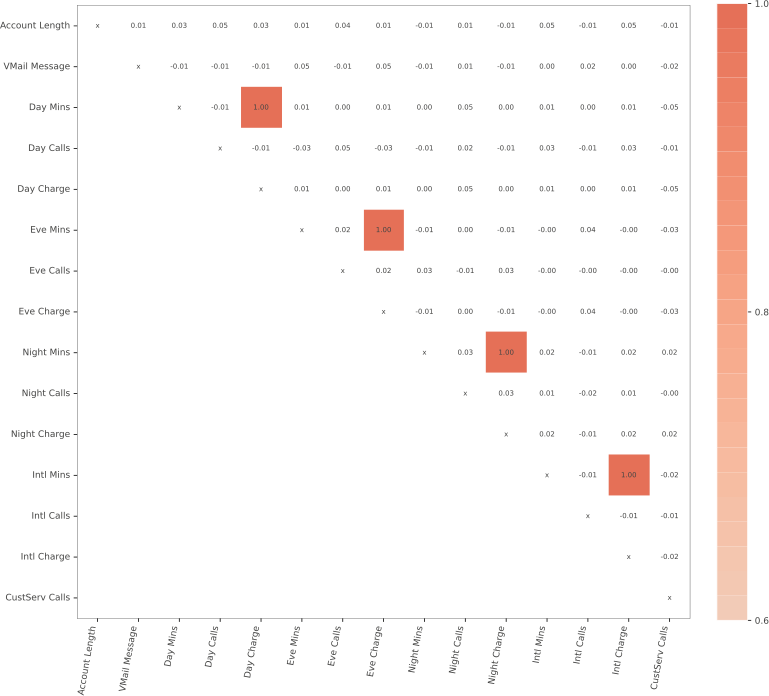

In [ ]:
viz = plot_corr_heatmap(Xtest[cont_vars], figsize=(11,11), label_fontsize=9, value_fontsize=7)
viz

In [ ]:
D = feature_dependence_matrix(Xtrain[cont_vars], sort_by_dependence=True)

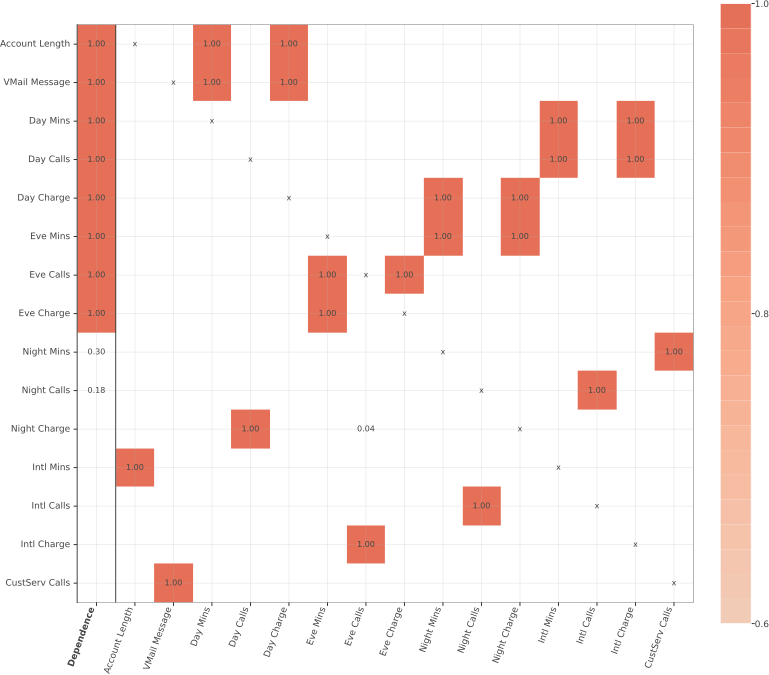

In [ ]:
viz = plot_dependence_heatmap(D, figsize=(11,10))
viz

## Eliminating Colinearity

In [ ]:
cont_vars

['Account Length',
 'VMail Message',
 'Day Mins',
 'Day Calls',
 'Day Charge',
 'Eve Mins',
 'Eve Calls',
 'Eve Charge',
 'Night Mins',
 'Night Calls',
 'Night Charge',
 'Intl Mins',
 'Intl Calls',
 'Intl Charge',
 'CustServ Calls']

In [ ]:
corrs.apply(np.abs).sum(axis=1).sort_values()

Eve Calls         1.097226
CustServ Calls    1.184662
Day Calls         1.212402
Night Calls       1.223645
VMail Message     1.260319
Intl Calls        1.274190
Account Length    1.289455
Night Charge      2.196765
Night Mins        2.196895
Intl Mins         2.216635
Intl Charge       2.216635
Day Mins          2.218664
Day Charge        2.218664
Eve Charge        2.289623
Eve Mins          2.289718
dtype: float64

In [ ]:
new_cont_vars = ['Account Length',
 'VMail Message',
 'Day Calls',
 'Day Charge',
 'Eve Calls',
 'Eve Charge',
 'Night Calls',
 'Night Mins',
 'Intl Calls',
 'Intl Charge',
 'CustServ Calls']

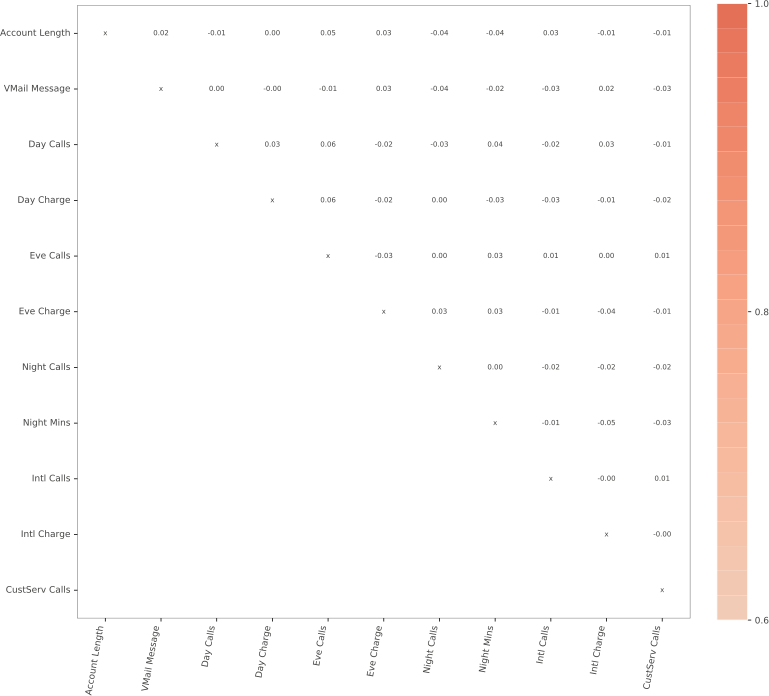

In [ ]:
viz = plot_corr_heatmap(Xtest[new_cont_vars], figsize=(11,11), label_fontsize=9, value_fontsize=7)
viz

In [ ]:
D = feature_dependence_matrix(Xtrain[new_cont_vars], sort_by_dependence=True)

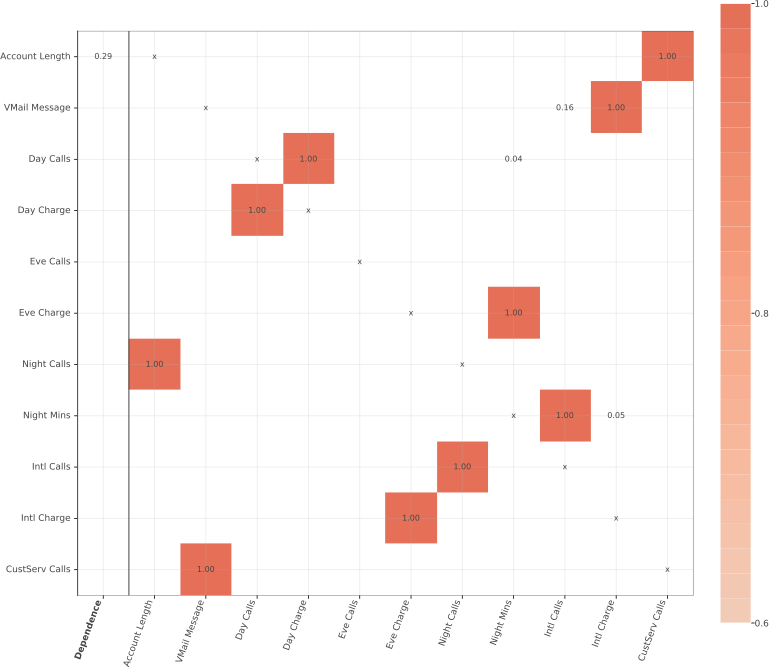

In [ ]:
viz = plot_dependence_heatmap(D, figsize=(11,10))
viz

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfclf_smaller = RandomForestClassifier(n_estimators=300)
from sklearn.preprocessing import OrdinalEncoder
oe3 = OrdinalEncoder()
cat_pipe3 = Pipeline([('orden', oe3)])
transformers3 = [('cat', cat_pipe3, pure_cat_vars)]
ct3 = ColumnTransformer(transformers=transformers3, remainder="passthrough")
rf2 = Pipeline(steps=[('ct', ct3), ('model', rfclf_smaller)])

In [ ]:
rf2, _  = do_classify(rf2, {"model__max_features": range(2,10,1)},
    dfchurn, new_cont_vars+cat_vars, 'Churn?', "True.", 
    reuse_split=reuse_split, score_func="roc_auc")

using reuse split
SCORE FUNC roc_auc
BEST {'model__max_features': 9} 0.8992042004938682
############# based on standard predict 0.5 ################
Accuracy on training data: 1.00
Accuracy on test data:     0.96
[[1129   10]
 [  45  150]]
########################################################


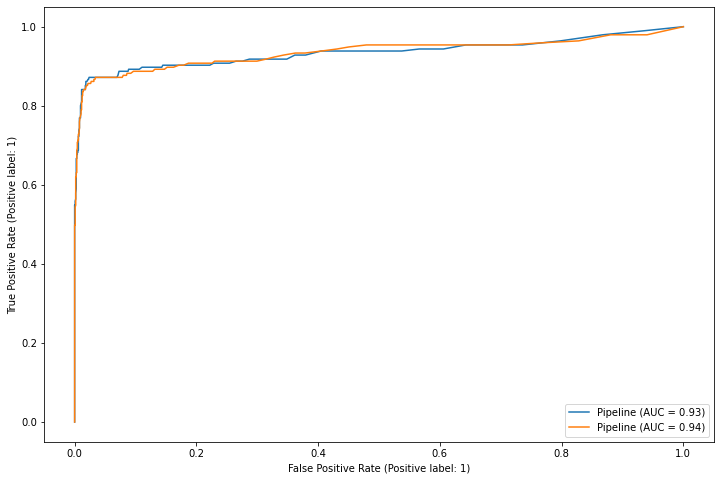

In [ ]:
from sklearn.metrics import plot_roc_curve
fig, ax = plt.subplots(figsize=(12,8))
plot_roc_curve(rf, Xtest, ytest, ax=ax )
plot_roc_curve(rf2, Xtest[new_cont_vars+cat_vars], ytest, ax=ax)

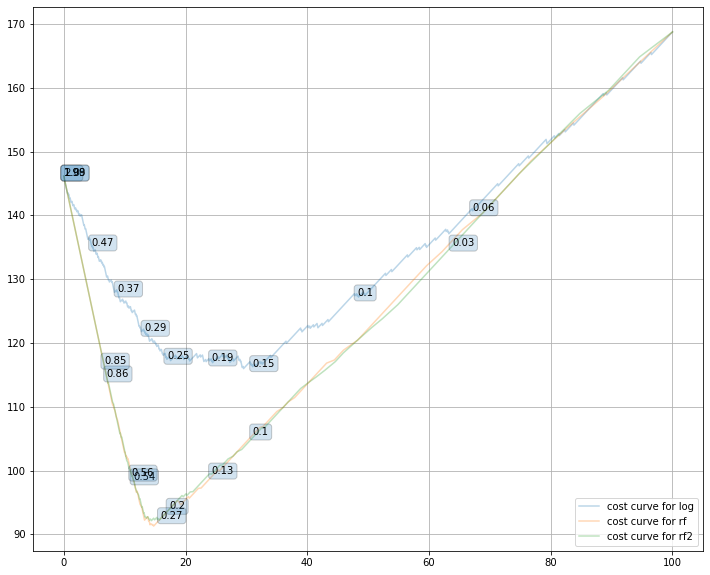

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
ax = plot_cost("log",pipe, ytest, Xtest, cost, ax=ax, threshold=True, labe=30);
plot_cost("rf",rf, ytest, Xtest, cost, ax, threshold=True, labe=30);
plot_cost("rf2",rf2, ytest, Xtest[new_cont_vars+cat_vars], cost, ax, threshold=True, labe=30);
ax.grid()

<AxesSubplot:xlabel='importance', ylabel='features'>

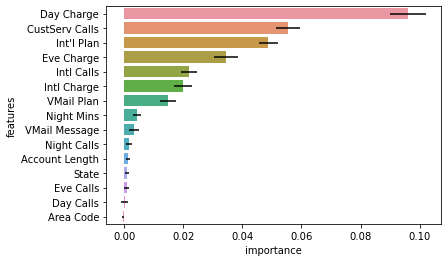

In [ ]:
pfi_test = permutation_importance(rf2, Xtest[new_cont_vars+cat_vars], ytest, n_repeats=30)
pfitestdf = feature_importance(new_cont_vars+cat_vars, pfi_test['importances_mean'], pfi_test['importances_std'])
sns.barplot(data=pfitestdf, y="features", x="importance", xerr=pfitestdf.importance_std)

## More techniques for imbalance


In [ ]:
Xtrain[ytrain==1].sample(np.sum(ytrain==0), replace=True).shape

(1711, 19)

In [ ]:
Xtrain[ytrain==0].shape

(1711, 19)

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline as mpimb
from imblearn.pipeline import Pipeline as PipelineImb

In [ ]:
rfclf_imb = RandomForestClassifier(n_estimators=300)
from sklearn.preprocessing import OrdinalEncoder
oe4 = OrdinalEncoder()
cat_pipe4 = Pipeline([('orden', oe4)])
transformers4 = [('cat', cat_pipe4, pure_cat_vars)]
ct4 = ColumnTransformer(transformers=transformers4, remainder="passthrough")
rf4 = PipelineImb(steps=[('sample', RandomOverSampler(random_state=1991)), ('ct', ct4), ('model', rfclf_imb)])

In [ ]:
rf4, _  = do_classify(rf4, {"model__max_features": range(2,10,1)},
    dfchurn, new_cont_vars+cat_vars, 'Churn?', "True.", 
    reuse_split=reuse_split, score_func="roc_auc")

using reuse split
SCORE FUNC roc_auc
BEST {'model__max_features': 5} 0.9022866779753974
############# based on standard predict 0.5 ################
Accuracy on training data: 1.00
Accuracy on test data:     0.96
[[1121   18]
 [  39  156]]
########################################################


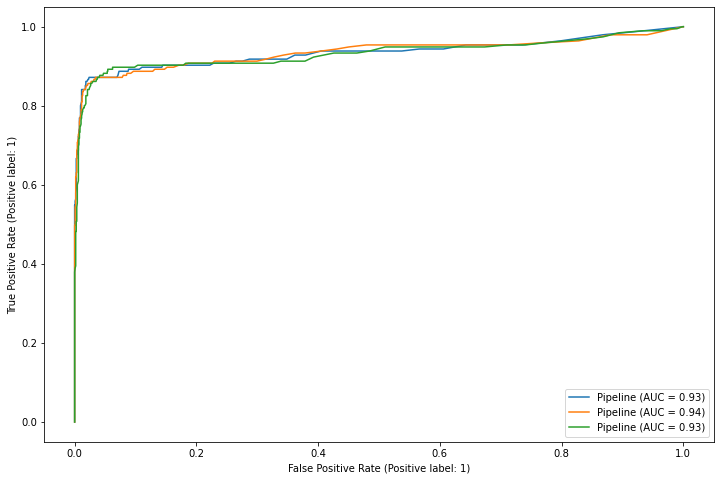

In [ ]:
from sklearn.metrics import plot_roc_curve
fig, ax = plt.subplots(figsize=(12,8))
plot_roc_curve(rf, Xtest, ytest, ax=ax )
plot_roc_curve(rf2, Xtest[new_cont_vars+cat_vars], ytest, ax=ax)
plot_roc_curve(rf4, Xtest[new_cont_vars+cat_vars], ytest, ax=ax)